## Note: Please change directory paths where ever necessary

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = '/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment1/AIP2023-Assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."


Mounted at /content/drive


In [2]:
!pip install split-folders
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import image as mpimg

import os
import shutil
import time
import splitfolders

from pandas.core.common import flatten
import copy
import numpy as np
import random

from PIL import Image

import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

from sklearn.metrics import classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
##Code to split train data folder into train and val folders
##Please change the input and output folder paths before running this 
##This might take 3-4 mins to run
input_folder = '{}/assignment1_data/classification_dataset/'.format(FOLDERNAME) + 'train'
output_folder = '{}/assignment1_data/classification_dataset/'.format(FOLDERNAME) + 'split'
splitfolders.ratio(input_folder, output = output_folder, ratio = (0.8, 0.2), group_prefix=None, move = False )

Copying files: 532 files [03:44,  2.37 files/s]


In [4]:
##Class to define the model
class ResNet18FineTuned(torch.nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    model = torchvision.models.resnet18(weights = torchvision.models.ResNet18_Weights.DEFAULT)
    for param in model.parameters():
            param.requires_grad = False
    num_in_features = model.fc.in_features
    model.fc = nn.Linear(in_features = num_in_features, out_features = num_classes)
    self.model = model
  
  def forward(self, x):
    out = self.model(x)
    return out

In [5]:
##Function to train model
def train_model(model, scheduler, dataloaders, criterion, optimizer, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict)     ##state_dict - Python dicionary which maps each layer to its parameter tensor
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
    
      running_loss = 0.00
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()   # zero the parameter gradients at the start of training loop

        with torch.set_grad_enabled(phase == 'train'):

          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model


In [6]:
##Function to show image use matplotlib
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [7]:
##this function helps to visualize the predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        # model.train(mode=was_training)

In [8]:
##Function to test the model
def test_model(model, dataloader):
  model.eval()
  test_labels = []
  pred_labels = []
  with torch.no_grad():
    running_corrects = 0
    for i, (inputs, labels) in enumerate(dataloaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      
      
      running_corrects += torch.sum(preds == labels.data)
      test_labels.append(labels.cpu().detach().numpy())
      pred_labels.append(preds.cpu().detach().numpy())

      # pred = preds.cpu().numpy()
      # labels = labels.cpu().numpy()
      # print(preds, labels)

    running_corrects = running_corrects.cpu().numpy()
    test_acc = float(running_corrects) / len(dataloaders['test'].dataset)
    # print(running_corrects)
    # print(len(dataloaders['test'].dataset))
    print("Test Accuracy- ", test_acc)
    test_labels = np.array(test_labels).flatten()
    pred_labels = np.array(pred_labels).flatten()
    report = classification_report(test_labels, pred_labels)
    return report


In [9]:
##This function deletes the split folder
def cleanup():
  dir = '{}/assignment1_data/classification_dataset/split'.format(FOLDERNAME)
  if os.path.exists(dir):
    shutil.rmtree(dir)

In [10]:
##Data Transforms for train, test and val datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:
##Code for data preparation and loading
split_dir = '{}/assignment1_data/classification_dataset/'.format(FOLDERNAME) + 'split'
test_dir = '{}/assignment1_data/classification_dataset/'.format(FOLDERNAME) + 'test'
image_datasets = { x : torchvision.datasets.ImageFolder(os.path.join(split_dir, x), transform=data_transforms[x]) for x in ['train', 'val'] }
image_datasets['test'] = torchvision.datasets.ImageFolder(test_dir, data_transforms['test']) 
shuffle_datasets = {'train': True, 'val': True, 'test': False}
dataloaders = { x : torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle = shuffle_datasets[x], num_workers = 2) for x in ['train', 'val', 'test'] }

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
##Model Initialization
model_ft = ResNet18FineTuned(len(image_datasets['train'].classes))

model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
##Setting hyperparameters for training
params_to_update = []
for name,param in model_ft.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print("Parameters to Update by optimizer:",name)
    
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, exp_lr_scheduler, dataloaders, criterion, optimizer_ft)

Parameters to Update by optimizer: model.fc.weight
Parameters to Update by optimizer: model.fc.bias
Epoch 0/24
----------
train Loss: 1.4006 Acc: 0.4279
val Loss: 0.3024 Acc: 0.9358

Epoch 1/24
----------
train Loss: 0.9192 Acc: 0.6785
val Loss: 0.3125 Acc: 0.8349

Epoch 2/24
----------
train Loss: 0.8990 Acc: 0.6974
val Loss: 0.1738 Acc: 0.9358

Epoch 3/24
----------
train Loss: 0.7883 Acc: 0.7423
val Loss: 0.1630 Acc: 0.9358

Epoch 4/24
----------
train Loss: 0.7151 Acc: 0.7447
val Loss: 0.1312 Acc: 0.9541

Epoch 5/24
----------
train Loss: 0.7138 Acc: 0.7565
val Loss: 0.1161 Acc: 0.9541

Epoch 6/24
----------
train Loss: 0.6665 Acc: 0.7660
val Loss: 0.1328 Acc: 0.9450

Epoch 7/24
----------
train Loss: 0.6150 Acc: 0.7943
val Loss: 0.1184 Acc: 0.9725

Epoch 8/24
----------
train Loss: 0.5759 Acc: 0.7967
val Loss: 0.1273 Acc: 0.9633

Epoch 9/24
----------
train Loss: 0.5564 Acc: 0.8014
val Loss: 0.1053 Acc: 0.9633

Epoch 10/24
----------
train Loss: 0.5181 Acc: 0.8203
val Loss: 0.1078

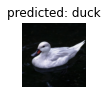

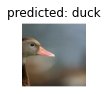

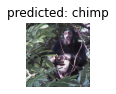

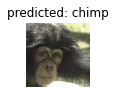

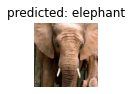

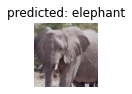

In [14]:
##Code to visualize model predictions
visualize_model(model_ft, 6)

In [15]:
##Code to test model and generate report
model_ft = model_ft.to(device)
report = test_model(model_ft, dataloaders)
print(report)

Test Accuracy-  0.9916666666666667
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       1.00      1.00      1.00        20
           2       0.95      1.00      0.98        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



# Experiments

In [ ]:
def experiment_model(model, scheduler, dataloaders, criterion, optimizer, num_epochs=25):
  train_acc = []
  train_loss = []
  test_acc = []
  test_loss = []
  epoch_num = []

  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict)     ##state_dict - Python dicionary which maps each layer to its parameter tensor
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['test','train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
    
      running_loss = 0.00
      running_corrects = 0.0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()   # zero the parameter gradients at the start of training loop

        with torch.set_grad_enabled(phase == 'train'):

          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).detach().cpu().numpy()

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects / len(dataloaders[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      if phase == 'train':
        train_acc.append(epoch_acc)
        train_loss.append(epoch_loss)

      if phase == 'test':
        test_acc.append(epoch_acc)
        test_loss.append(epoch_loss)

      if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

      epoch_num.append(epoch)

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return train_acc, train_loss, test_acc, test_loss, epoch_num


In [ ]:
model_ft = ResNet18FineTuned(len(image_datasets['train'].classes))

model_ft = model_ft.to(device)

In [ ]:
params_to_update = []
for name,param in model_ft.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print("Parameters to Update by optimizer:",name)
    
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
train_acc_SGD_CEL, train_loss_SGD_CEL, test_acc_SGD_CEL, test_loss_SGD_CEL, epoch_num_SGD_CEL = experiment_model(model_ft, exp_lr_scheduler, dataloaders, criterion, optimizer_ft, num_epochs=30)

Parameters to Update by optimizer: model.fc.weight
Parameters to Update by optimizer: model.fc.bias
Epoch 0/29
----------
test Loss: 2.1122 Acc: 0.1417
train Loss: 1.4085 Acc: 0.4468
val Loss: 0.3566 Acc: 0.9083

Epoch 1/29
----------
test Loss: 0.3642 Acc: 0.8833
train Loss: 0.8685 Acc: 0.6879
val Loss: 0.1949 Acc: 0.9633

Epoch 2/29
----------
test Loss: 0.1917 Acc: 0.9417
train Loss: 0.7711 Acc: 0.7163
val Loss: 0.1402 Acc: 0.9633

Epoch 3/29
----------
test Loss: 0.1308 Acc: 0.9750
train Loss: 0.7525 Acc: 0.7565
val Loss: 0.1433 Acc: 0.9450

Epoch 4/29
----------
test Loss: 0.1826 Acc: 0.9333
train Loss: 0.7003 Acc: 0.7612
val Loss: 0.1101 Acc: 0.9541

Epoch 5/29
----------
test Loss: 0.1032 Acc: 0.9750
train Loss: 0.6915 Acc: 0.7518
val Loss: 0.1106 Acc: 0.9541

Epoch 6/29
----------
test Loss: 0.1345 Acc: 0.9833
train Loss: 0.6697 Acc: 0.7707
val Loss: 0.1422 Acc: 0.9450

Epoch 7/29
----------
test Loss: 0.1220 Acc: 0.9583
train Loss: 0.6522 Acc: 0.7707
val Loss: 0.1093 Acc: 0.98

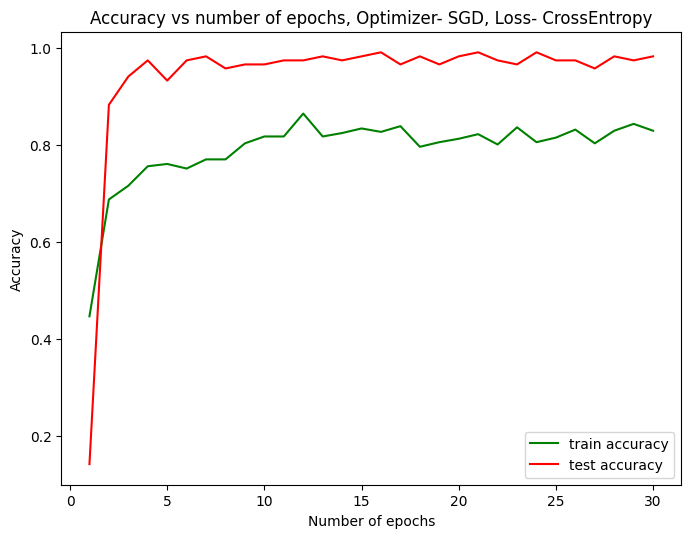

In [ ]:

epoch_num = range(1,31)
plt.figure(figsize=(8,6), dpi=100)
plt.plot(epoch_num, train_acc_SGD_CEL, 'g', label = 'train accuracy')
plt.plot(epoch_num, test_acc_SGD_CEL, 'r', label = 'test accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy vs number of epochs, Optimizer- SGD, Loss- CrossEntropy')
plt.legend()
plt.show()

In [ ]:
model_ft = ResNet18FineTuned(len(image_datasets['train'].classes))
model_ft = model_ft.to(device)
params_to_update = []
for name,param in model_ft.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print("Parameters to Update by optimizer:",name)
    
optimizer_ft = optim.Adam(params_to_update, lr=0.001)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
train_acc_Adam_CEL, train_loss_Adam_CEL, test_acc_Adam_CEL, test_loss_Adam_CEL, epoch_num_SGD_CEL = experiment_model(model_ft, exp_lr_scheduler, dataloaders, criterion, optimizer_ft, num_epochs=30)

Parameters to Update by optimizer: model.fc.weight
Parameters to Update by optimizer: model.fc.bias
Epoch 0/29
----------
test Loss: 2.2376 Acc: 0.1500
train Loss: 1.5597 Acc: 0.3641
val Loss: 0.6575 Acc: 0.8073

Epoch 1/29
----------
test Loss: 0.7227 Acc: 0.7417
train Loss: 1.0732 Acc: 0.6265
val Loss: 0.2841 Acc: 0.9725

Epoch 2/29
----------
test Loss: 0.3061 Acc: 0.9583
train Loss: 0.8346 Acc: 0.7258
val Loss: 0.1965 Acc: 0.9725

Epoch 3/29
----------
test Loss: 0.2039 Acc: 0.9667
train Loss: 0.8089 Acc: 0.7163
val Loss: 0.1610 Acc: 0.9725

Epoch 4/29
----------
test Loss: 0.1632 Acc: 0.9667
train Loss: 0.8086 Acc: 0.7069
val Loss: 0.1700 Acc: 0.9633

Epoch 5/29
----------
test Loss: 0.1578 Acc: 0.9667
train Loss: 0.7473 Acc: 0.7636
val Loss: 0.1601 Acc: 0.9358

Epoch 6/29
----------
test Loss: 0.1399 Acc: 0.9667
train Loss: 0.7484 Acc: 0.7400
val Loss: 0.1444 Acc: 0.9358

Epoch 7/29
----------
test Loss: 0.1150 Acc: 0.9833
train Loss: 0.6067 Acc: 0.7896
val Loss: 0.1357 Acc: 0.95

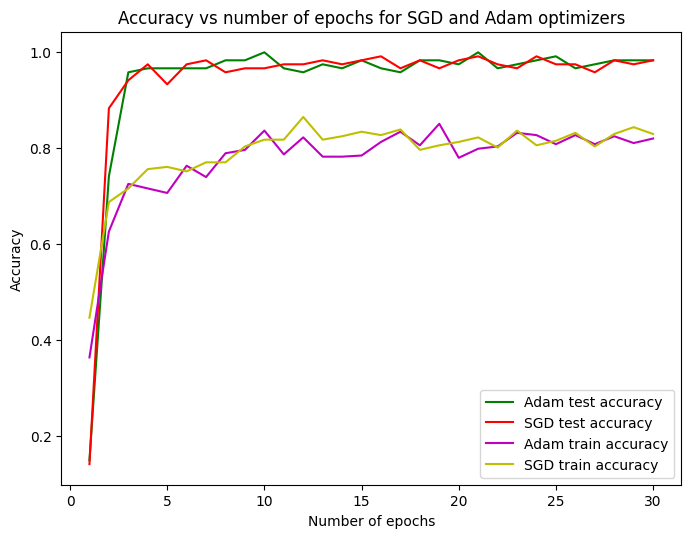

In [ ]:
epoch_num = range(1,31)
plt.figure(figsize=(8,6), dpi=100)
plt.plot(epoch_num, test_acc_Adam_CEL, 'g', label = 'Adam test accuracy')
plt.plot(epoch_num, test_acc_SGD_CEL, 'r', label = 'SGD test accuracy')

plt.plot(epoch_num, train_acc_Adam_CEL, 'm', label = 'Adam train accuracy')
plt.plot(epoch_num, train_acc_SGD_CEL, 'y', label = 'SGD train accuracy')

plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy vs number of epochs for SGD and Adam optimizers')
plt.legend()
plt.show()

In [ ]:
cleanup()